In [1]:
# Import
import pandas as pd
from finta import TA as ta
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import yfinance as yf

# Setting these options will allow for reviewing more of the DataFrames
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 2000)
pd.set_option('display.width', 1000)

In [17]:
df = yf.download("BTC-USD", interval="1h", start="2020-05-01", end=pd.to_datetime('today'))

df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
2022-04-04 20:00:00+00:00,45925.679688,46310.769531,45817.121094,46301.804688,46301.804688,1810339840
2022-04-04 21:00:00+00:00,46315.363281,46530.292969,46263.109375,46491.546875,46491.546875,658077696
2022-04-04 22:00:00+00:00,46478.527344,46479.742188,46447.292969,46449.007812,46449.007812,0
2022-04-05 00:00:00+00:00,46610.718750,46632.105469,46477.593750,46541.160156,46541.160156,94144512
2022-04-05 00:53:00+00:00,46538.164062,46538.164062,46538.164062,46538.164062,46538.164062,0


In [18]:
def appendData(maindf, dataarray, namesarray=None):
    if namesarray==None:
        return maindf.join(pd.DataFrame(dataarray), how='outer')
    return maindf.join(pd.DataFrame(dataarray,columns=namesarray), how='outer')

In [19]:
### Oscillators ###
## RSI
df = appendData(df,ta.RSI(df))
## Sto-%K
df = appendData(df,ta.STOCH(df))
## CCI
df = appendData(df,ta.CCI(df))
## ADX
df = appendData(df,ta.ADX(df))
## DMI (Added to aid in interpreting ADX)
df = appendData(df,ta.DMI(df, 14))
## Awesome
df = appendData(df,ta.AO(df))
## Momentum
df = appendData(df,ta.MOM(df,10))
## MACD (We rename the undescriptive "SIGNAL" here)
df = appendData(df,ta.MACD(df)).rename(columns={"SIGNAL": "MACD SIGNAL"})
## Sto-RSI
df = appendData(df,ta.STOCHRSI(df))
## Williams %R
df = appendData(df,ta.WILLIAMS(df))
## Bull-Bear Power
df = appendData(df,ta.EBBP(df))
## Ultimate (FinTA does not name this column, so we must)
df = appendData(df,ta.UO(df),["UO"])
### Moving Averages ###
sma_ema_averages = [5, 10, 20, 30, 50, 100, 200]
## SMA, EMA
for i in sma_ema_averages:
  df = appendData(df,ta.SMA(df, i))
  df = appendData(df,ta.EMA(df, i))
## VWMA
df = appendData(df, ta.VAMA(df, 20))
## Hull
df = appendData(df,ta.HMA(df, 9))
# Ichimoku -- Base (Kijun) and Conversion (Tenkan) Only
df = appendData(df,ta.ICHIMOKU(df).drop(['senkou_span_a','SENKOU','CHIKOU'], axis=1))

In [42]:
# Use the pct_change function to generate the returns from "close"
df["actual_return"] = df["Close"].pct_change()

df["three_period_return"] = df["Close"].pct_change(periods=3)

df["five_period_return"] = df["Close"].pct_change(periods=5)
# Drop all NaN values from the DataFrame
df = df.dropna()

df.head()

,Open,High,Low,Close,Adj Close,Volume,14 period RSI,14 period STOCH %K,20 period CCI,14 period ADX.,DI+,DI-,AO,MOM,MACD,MACD SIGNAL,14 period stochastic RSI.,14 Williams %R,Bull.,Bear.,UO,5 period SMA,5 period EMA,10 period SMA,10 period EMA,20 period SMA,20 period EMA,30 period SMA,30 period EMA,50 period SMA,50 period EMA,100 period SMA,100 period EMA,200 period SMA,200 period EMA,20 period VAMA,9 period HMA.,TENKAN,KIJUN,actual_returns,three_period_return,five_period_return,signal,actual_return
2020-05-10 11:00:00+00:00,8821.774414,8821.774414,8724.694336,8743.088867,8743.088867,0,28.709993,19.697470,-52.192401,49.766926,15.557955,49.079186,-588.282092,16.755859,-254.834398,-252.239836,0.244457,-80.302530,-74.890643,-171.970722,54.418154,8809.401953,8780.279147,8720.903906,8837.906952,9111.023340,9034.222849,9306.268262,9183.694368,9550.681133,9335.152738,9490.605273,9384.974760,9200.531025,9319.626061,9035.705515,8854.369231,8700.238281,9141.539551,-0.011120,-0.011120,0.013891,0.0,-0.008586
2020-05-10 12:00:00+00:00,8746.992188,8778.591797,8731.430664,8741.208008,8741.208008,0,28.652932,19.532650,-49.816314,49.916476,14.446672,45.573529,-548.013821,53.319336,-246.743238,-251.140517,0.237745,-80.467350,-95.865111,-143.026244,49.101215,8793.843164,8767.255434,8726.235840,8820.325326,9063.675928,9006.316673,9270.603092,9155.146844,9528.036387,9311.856503,9487.940635,9372.051580,9200.356348,9313.111871,9035.705515,8804.512876,8700.238281,9141.539551,-0.009462,-0.009462,-0.008821,0.0,-0.000215
2020-05-10 13:00:00+00:00,8742.799805,8808.630859,8729.589844,8797.369141,8797.369141,272936960,32.938833,25.904294,-41.762708,49.784473,14.842153,42.318276,-531.546062,147.321289,-233.112031,-247.534819,0.234201,-74.095706,-54.813510,-133.854526,52.571916,8785.036328,8777.293336,8740.967969,8816.151474,9016.199658,8986.416908,9239.441797,9132.064399,9506.989824,9291.676963,9485.821387,9360.518361,9200.496758,9307.311145,9014.419652,8773.884538,8718.530762,9141.539551,-0.002431,-0.002431,-0.004980,0.0,0.006425
2020-05-10 14:00:00+00:00,8796.182617,8797.979492,8720.365234,8733.524414,8733.524414,0,30.682367,59.148125,-42.984892,49.715301,13.781999,40.070832,-514.126583,181.723633,-224.868789,-243.001613,0.248888,-40.851875,-46.904884,-124.519141,44.831709,8766.799609,8762.703695,8759.140332,8801.128372,8965.237061,8962.331909,9209.283887,9106.352128,9482.655410,9269.784911,9482.935449,9347.938668,9199.880303,9300.865939,9014.419652,8750.699175,8744.960938,9141.539551,-0.001094,-0.001094,-0.010333,0.0,-0.007257
2020-05-10 15:00:00+00:00,8714.474609,8714.474609,8652.876953,8655.541016,8655.541016,0,28.146071,37.715720,-55.050252,50.020759,12.797571,42.834013,-502.877220,6.547852,-222.068700,-238.815031,0.261773,-62.284280,-103.360715,-164.958371,40.251546,8734.146289,8726.982802,8759.795117,8774.657944,8912.112646,8933.113728,9174.627441,9077.267526,9457.643184,9245.692986,9478.957754,9334.050379,9198.668979,9293.626447,8923.144663,8713.752608,8752.763672,9141.539551,-0.009800,-0.009800,-0.018513,0.0,-0.008929


In [32]:

investment_amount = 10000 * .05

# Initialize the new `Signal` column
df['signal'] = 0.0
# Generate signal to buy stock long
df.loc[(df['three_period_return'] >= ((investment_amount * 0.00001))), 'signal'] = 1
# Generate signal to sell stock short
#df.loc[(df['three_period_return'] < (investment_amount * 0.00001)), 'signal'] = 0

In [33]:
# Copy the new "signal" column to a new Series called `y`.
y = df['signal']
# set up X for ml 
X = df[["14 period RSI", "14 period STOCH %K", "20 period CCI", "14 period ADX.", "DI+", "DI-", "AO", "MOM", "MACD", "MACD SIGNAL", "14 period stochastic RSI.", "14 Williams %R", "Bull.", "Bear.", "UO", "5 period SMA", "5 period EMA", "10 period SMA", "10 period EMA", "20 period SMA", "20 period EMA", "30 period SMA", "30 period EMA", "50 period SMA", "50 period EMA", "100 period SMA", "100 period EMA", "200 period SMA", "200 period EMA", "20 period VAMA", "9 period HMA.", "TENKAN", "KIJUN"]].shift().dropna().copy()

In [34]:
# value counts for -1 and 1
y.value_counts()

0.0    11468
1.0     4507
Name: signal, dtype: int64

In [35]:
# Use the following code to select the start of the training period: `training_begin = X.index.min()`
training_begin = X.index.min()
print(training_begin)

# Use the following code to select the ending period for the training data: `training_end = X.index.min() + DateOffset(months=3)`
training_end = X.index.min() + DateOffset(months=3)
print(training_end)

# Generate the X_train and y_train DataFrames using loc to select the rows from `training_begin` up to `training_end`
# Hint: Use `loc[training_begin:training_end]` for X_train and y_train
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Generate the X_test and y_test DataFrames using loc to select from `training_end` to the last row in the DataFrame.
# Hint: Use `loc[training_end:]` for X_test and y_test
X_test = X.loc[training_end:]
y_test = y.loc[training_end:]

# Use StandardScaler to scale the X_train and X_test data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

2020-05-10 07:00:00+00:00
2020-08-10 07:00:00+00:00


In [36]:
model = SVC()
 
# Fit the model to the data using X_train_scaled and y_train
model = model.fit(X_train_scaled, y_train)

# Use the trained model to predict the trading signals for the training data.
training_signal_predictions = model.predict(X_train_scaled)

# Evaluate the model using a classification report
from sklearn.metrics import classification_report
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

         0.0       0.85      0.99      0.92      1720
         1.0       0.87      0.23      0.36       378

    accuracy                           0.86      2098
   macro avg       0.86      0.61      0.64      2098
weighted avg       0.86      0.86      0.82      2098



In [37]:
# Use the trained model to predict the trading signals for the testing data.
testing_signal_predictions = model.predict(X_test_scaled)

# Evaluate the model's ability to predict the trading signal for the testing data using a classification report
training_report = classification_report(y_test, testing_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

         0.0       0.70      1.00      0.83      9748
         1.0       0.64      0.01      0.02      4129

    accuracy                           0.70     13877
   macro avg       0.67      0.50      0.42     13877
weighted avg       0.69      0.70      0.59     13877



In [66]:
 # Create a new empty predictions DataFrame using code provided below.
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df['signal'] = testing_signal_predictions
predictions_df['signal'].value_counts()
predictions_df["three_period_return"] = df["three_period_return"]


intial_investment = 10000
# Add in actual returns and calculate trading returns
predictions_df['actual_return'] = df['actual_return']
predictions_df['trading_algorithm_returns_3'] = predictions_df.loc[predictions_df["signal"]==1]["three_period_return"]
#predictions_df["trading_algorithm_returns_5"] = 
predictions_df["trading_algorithm_returns_3"].fillna(0, inplace=True)
predictions_df["trading_algo_returns_3_+1"] = ((predictions_df["trading_algorithm_returns_3"] + 1) * intial_investment)
# we need to add trading algo cumulative returns in order to plot agaisnt actual returns and see how well our algo performed compared to actual returns

predictions_df[50:100]

,signal,three_period_return,actual_return,trading_algorithm_returns_3,trading_algo_returns_3_+1
2020-08-12 11:00:00+00:00,0.0,0.003364,-0.001602,0.000000,10000.000000
2020-08-12 12:00:00+00:00,0.0,0.000562,0.000811,0.000000,10000.000000
2020-08-12 13:00:00+00:00,0.0,0.003629,0.004425,0.000000,10000.000000
2020-08-12 14:00:00+00:00,0.0,0.009445,0.004183,0.000000,10000.000000
2020-08-12 15:00:00+00:00,0.0,0.006991,-0.001622,0.000000,10000.000000
2020-08-12 16:00:00+00:00,0.0,0.002576,0.000021,0.000000,10000.000000
2020-08-12 17:00:00+00:00,0.0,-0.004376,-0.002779,0.000000,10000.000000
2020-08-12 18:00:00+00:00,0.0,-0.004830,-0.002078,0.000000,10000.000000
2020-08-12 19:00:00+00:00,0.0,0.000476,0.005353,0.000000,10000.000000
2020-08-12 20:00:00+00:00,0.0,0.001486,-0.001772,0.000000,10000.000000


<AxesSubplot:>

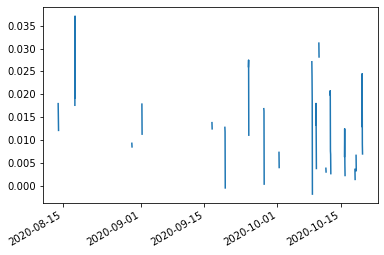

In [60]:
# Calculate and plot the cumulative returns for the `actual_returns` and the `trading_algorithm_returns`

(1 + predictions_df[['actual_return', 'trading_algo_returns_3_+1']]).cumprod().plot()